<a href="https://colab.research.google.com/github/gorozco21/streamlit-example/blob/discord/Discord_2024_02_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import matplotlib.colors as mcolors
import matplotlib

styled_image.png


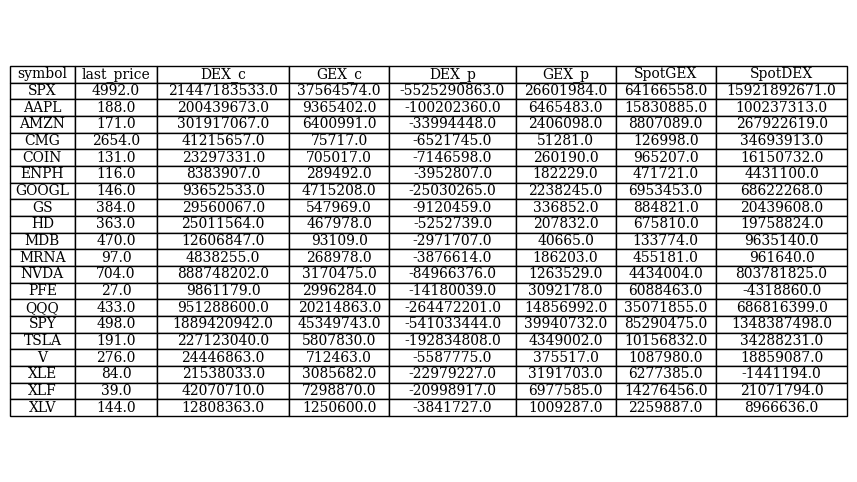

In [ ]:
# Clave de API de Tradier
api_key = 'kLtiHlJBYMfZ7WAyn0tPqGB75gHn'

# Añade aquí los símbolos de los stocks que te interesan
#symbols = ['SPX', 'SPY']
symbols = ['SPX', 'AAPL',  'AMZN',  'CMG',  'COIN',  'ENPH',  'GOOGL',  'GS',  'HD',  'MDB',  'MRNA',  'NVDA',  'PFE',  'QQQ',  'SPY',  'TSLA',  'V',  'XLE',  'XLF',  'XLV']

# URL base para la cadena de opciones (ajústala según la API correcta que estés usando)
url_base = 'https://cdn.cboe.com/api/global/delayed_quotes/options/'

# Lista para almacenar DataFrames
dfs = []

for symbol in symbols:
    # Construir la URL completa para la solicitud de la API
    url_chain = f'{url_base}_{"SPX"}.json' if symbol == 'SPX' else f'{url_base}{symbol}.json'

    # Realizar la solicitud GET a la API
    try:
        response = requests.get(url_chain)
        response.raise_for_status()  # Lanza un error para estados de respuesta 4xx/5xx
    except requests.RequestException as e:
        print(f"Error al solicitar datos para {symbol}: {e}")
        continue

    # Analizar la respuesta JSON
    data = response.json()

    # Extraer la lista de opciones
    options_list = data['data']['options']

    # Convertir a DataFrame de pandas
    df = pd.DataFrame(options_list)

    # Define the combined DataFrame for calls and puts
    # Función para determinar el tipo de opción
    def get_option_type(option_id):
        # Busca la primera 'C' o 'P' desde el final del string
        match = re.search(r'[CP](?!.*[CP])', option_id)
        if match:
            return 'call' if match.group() == 'C' else 'put'
        else:
            return 'unknown'  # Devuelve 'unknown' si no se encuentra ninguna 'C' o 'P'

    def get_option_segments(option_id):
        # Busca la primera 'C' o 'P' desde el final del string
        match = re.search(r'[CP](?!.*[CP])', option_id)
        if match:
            # Encuentra el índice de la primera 'C' o 'P' encontrada
            index = match.start()
            # Devuelve el segmento antes de 'C'/'P' y el segmento después
            return option_id[:index], option_id[index+1:]
        else:
            # Devuelve 'unknown' para ambos segmentos si no se encuentra 'C' o 'P'
            return 'unknown', 'unknown'

    def get_last_price_tradier(symbol):

        # Endpoint para obtener cotizaciones
        url = f'https://api.tradier.com/v1/markets/quotes?symbols={symbol}'

        # Encabezados necesarios para la solicitud
        headers = {
            'Authorization': f'Bearer {api_key}',
            'Accept': 'application/json'
        }

        try:
            # Realizar la solicitud GET
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Lanza un error para respuestas no exitosas
            # Procesar la respuesta JSON
            data = response.json()
            # Extraer el último precio
            last_price = data['quotes']['quote']['last']
            return last_price
        except requests.RequestException as e:
            print(f"Error al solicitar el último precio para {symbol}: {e}")
            return None

    df['last_price'] = get_last_price_tradier(symbol)

    df['GEX'] = df['last_price'] * df['open_interest'] * df['gamma']
    df['DEX'] = df['last_price'] * df['open_interest'] * df['delta']

    # Aplicar la función al DataFrame y expandir el resultado en dos nuevas columnas
    df[['col1', 'col2']] = df['option'].apply(lambda x: pd.Series(get_option_segments(x)))

    # Agregar una nueva columna 'option_type' usando la función definida
    df['option_type'] = df['option'].apply(get_option_type)

    calls_df = df[df['option_type'] == 'call']
    puts_df = df[df['option_type'] == 'put']
    combined_df = pd.merge(calls_df, puts_df, on=["col1", "col2", "last_price"], suffixes=('_c', '_p'))

    df3 = combined_df[['col1', 'col2', 'last_price', 'GEX_c', 'DEX_c', 'GEX_p', 'DEX_p']]
    df3 = df3.copy()
    df3.loc[:, 'symbol'] = symbol

    df3 = df3.groupby('symbol').agg({'last_price': 'mean', 'DEX_c': 'sum', 'GEX_c': 'sum', 'DEX_p': 'sum', 'GEX_p': 'sum'}).reset_index()
    df3['SpotGEX'] = df3['GEX_c'] + df3['GEX_p']
    df3['SpotDEX'] = df3['DEX_c'] + df3['DEX_p']

    # Append df3 to dfs
    dfs.append(df3)

# Combine all DataFrames
combined_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Redondear los números
combined_df = combined_df.round(0)

#Nuevo- Desde
# Configuración básica de la figura
plt.figure(figsize=(10, 0.3 * len(combined_df)))
ax = plt.gca()
ax.axis('off')

# Creación de la tabla
table = ax.table(cellText=combined_df.values, colLabels=combined_df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(combined_df.columns))))

# Ajuste de la escala de la tabla
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

# Guardar la figura
plt.savefig('styled_image.png', bbox_inches='tight', dpi=150)
print('styled_image.png')

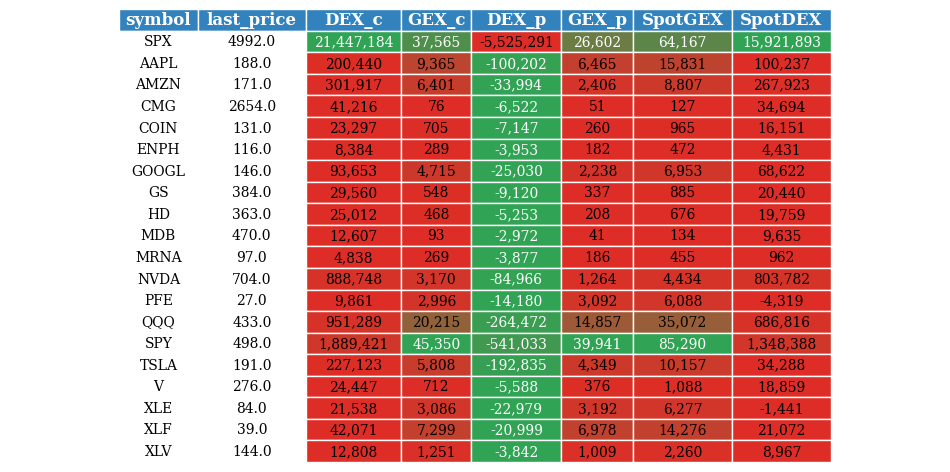

In [ ]:
# Define la función para formatear los valores
def format_value(value):
    # Redondear, dividir por 1000 y formatear con comas como separadores de miles
    return '{:,.0f}'.format(round(value / 1000, 2))

# Configuración de la fuente
matplotlib.rcParams['font.family'] = 'serif'  # Cambia 'serif' por la fuente que prefieras
matplotlib.rcParams['font.size'] = 10  # Ajusta el tamaño de la fuente aquí

# Configuración básica de la figura
plt.figure(figsize=(12, 0.2 * len(combined_df)))  # Ajusta el tamaño de la figura según el número de filas
ax = plt.gca()
ax.axis('off')
ax.set_facecolor('#f0f0f0')  # Color de fondo de la figura

# Creación de la tabla con estilo mejorado
table = ax.table(cellText=combined_df.values, colLabels=combined_df.columns, loc='center', cellLoc='center', colColours=['#6baed6']*len(combined_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(combined_df.columns))))  # Ajusta automáticamente el ancho de las columnas

# Aplicación de estilos adicionales a la tabla y reducción del alto de las celdas
min_cell_height = 0.07 # Ajusta este valor para reducir el alto de las celdas
for key, cell in table.get_celld().items():
    cell.set_edgecolor('w')  # Cambia el color de los bordes de las celdas a blanco
    cell.set_height(min_cell_height)  # Establece el alto mínimo de las celdas
    if key[0] == 0:  # Encabezados de la tabla
        cell.set_fontsize(12)  # Tamaño de fuente para los encabezados
        cell.set_text_props(weight='bold', color='white')  # Texto en negrita para los encabezados
        cell.set_facecolor('#3182bd')  # Color de fondo para los encabezados
    else:
        cell.set_text_props(color='black')  # Ajusta el color del texto para las celdas que no son encabezados

# Definir el mapa de colores para el gradiente
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#de2d26", "#31a354"])  # Rojo a verde

# Aplicar el gradiente a cada columna, excluyendo las primeras dos columnas
for j in range(2, len(combined_df.columns)):
    column_values = combined_df.iloc[:, j].astype(str).str.replace(',', '').astype(float)
    min_val, max_val = np.min(column_values[column_values != 0]), np.max(column_values)

    for i in range(len(combined_df)):
        value = column_values[i]
        if value == 0:
            color = 'white'
        else:
            normalized = (value - min_val) / (max_val - min_val) if max_val != min_val else 0.5
            color = cmap(normalized)

        table[(i+1, j)].set_facecolor(color)
        table[(i+1, j)].set_text_props(color='black' if value == 0 or normalized < 0.5 else 'white')

        formatted_value = format_value(value)
        table[(i+1, j)].get_text().set_text(formatted_value)

# Ajuste de la escala de la tabla
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

# Guardar la figura
plt.savefig('styled_image.png', bbox_inches='tight', dpi=150)



In [ ]:
# URL de webhook de Discord - Desarrollo
webhook_url = "https://discord.com/api/webhooks/1090845494919569509/FbLOpKFVpg3dt_kTzsQVdjm1tbCAHGB39gReeg08O-HjhWIN0_QECIDrKxO515v-czH6"

# URL de webhook de Discord - Producción
#webhook_url = "https://discord.com/api/webhooks/1082801469738201119/nsRi33z37wp0O2HJfEYAo-gtTcYBUjAOQanHT8M2WD5KvW8YP4DY04awyoMG_8O-tb7X"

file = {'file': open('styled_image.png', 'rb')}

response = requests.post(webhook_url, files=file)

# Verificar si la solicitud fue exitosa
if response.status_code == 200:
    print("Imagen enviada con éxito.")
else:
    print(f"Error al enviar la imagen: {response.status_code}")

Error al enviar la imagen: 200
